In [56]:
#Import libraries: Using ResNet50
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [70]:
#Set directories for the datasets
#reedited the datasets (adding new images from the Train Folder (20 each for chihuahua and muffin))
train_dir = "/content/muffin-vs-chihuahua-improved-dataset/train"
val_dir   = "/content/muffin-vs-chihuahua-improved-dataset/test"

In [58]:
#Create ImageDataGenerators
#this is useful for image augmentation
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,         #increase rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7,1.3]  #simulate lighting changes
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 4773 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [59]:
#Load Resnet50 (without top layers)
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False   # freeze ResNet50 layers

In [60]:
#Add your custom classifier (the “head” of the network)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [61]:
#compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
#train the model
#used early stopping to stop when accuracy and validation accuracy is good
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,  # stop if no improvement for 5 epochs
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 644ms/step - accuracy: 0.5179 - loss: 2.7305 - val_accuracy: 0.7424 - val_loss: 1.7060
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 586ms/step - accuracy: 0.6151 - loss: 1.5411 - val_accuracy: 0.7568 - val_loss: 1.0875
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 588ms/step - accuracy: 0.6502 - loss: 1.0345 - val_accuracy: 0.7508 - val_loss: 0.8139
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 586ms/step - accuracy: 0.6635 - loss: 0.8231 - val_accuracy: 0.7500 - val_loss: 0.7131
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 584ms/step - accuracy: 0.6883 - loss: 0.7318 - val_accuracy: 0.7660 - val_loss: 0.6602
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - accuracy: 0.6915 - loss: 0.6959 - val_accuracy: 0.7483 - val_loss: 0.6285
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - accuracy: 0.6887 - loss: 0.6739 - val_accuracy: 0.7753 - val_loss: 0.6149
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 582ms/step - accuracy: 0.6951 - loss: 

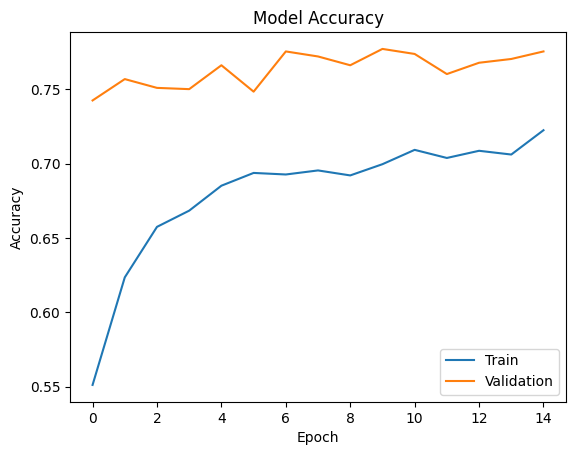

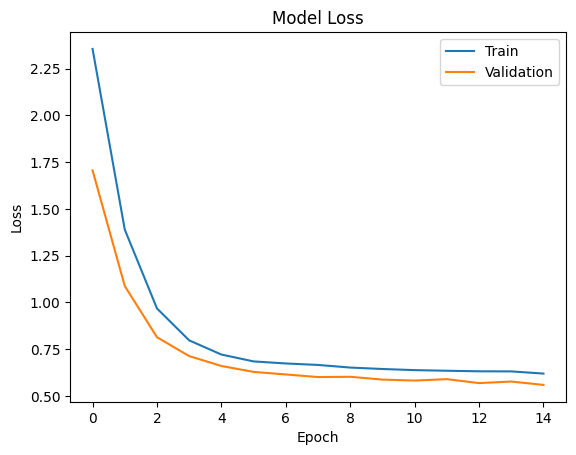

In [63]:
#Plot accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [64]:
#Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

#Unfreeze only the last 10 layers (you can adjust this)
for layer in base_model.layers[-10:]:
    layer.trainable = True

#Redefine the classifier head with dropout and L2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

#Compile the model with a small learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#EarlyStopping callback to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=2,          # stop if val_accuracy doesn't improve for 2 epochs
    restore_best_weights=True
)

#Fine-tune for 5 epochs
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 111s 654ms/step - accuracy: 0.5901 - loss: 3.0804 - val_accuracy: 0.4696 - val_loss: 3.1293
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 583ms/step - accuracy: 0.7213 - loss: 2.8172 - val_accuracy: 0.5017 - val_loss: 2.9534
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 587ms/step - accuracy: 0.7376 - loss: 2.6877 - val_accuracy: 0.7213 - val_loss: 2.6019
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 566ms/step - accuracy: 0.7613 - loss: 2.5360 - val_accuracy: 0.7922 - val_loss: 2.4038
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 567ms/step - accuracy: 0.7731 - loss: 2.4236 - val_accuracy: 0.8294 - val_loss: 2.2577


In [65]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8374 - loss: 2.2429
Validation Accuracy: 82.94%
Validation Loss: 2.2577


In [66]:
import os

predict_dir = "/content/predict_images/"
image_files = [f for f in os.listdir(predict_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]

In [67]:
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]

    # Correct mapping based on class_indices
    if prediction > 0.5:
        return f"Muffin ({prediction:.2f})"       # 1 = muffin
    else:
        return f"Chihuahua ({1-prediction:.2f})"  # 0 = chihuahua

In [68]:
for img_file in image_files:
    img_path = os.path.join(predict_dir, img_file)
    result = predict_image(img_path, model)
    print(f"{img_file}: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
predict_img4.jpg: Chihuahua (0.71)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
predict_img8.jpg: Muffin (0.78)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predict_img6.jpg: Muffin (0.52)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
predict_img9.jpg: Chihuahua (0.56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predict_img7.jpg: Chihuahua (0.61)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
predict_img5.jpg: Muffin (0.91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predict_img2.jpg: Muffin (0.88)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predict_img1.jpg: Muffin (0.91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predict_img10.jpg: Chihuahua (0.88)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
predict_img3.jpg: Chihuahua (0.94)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


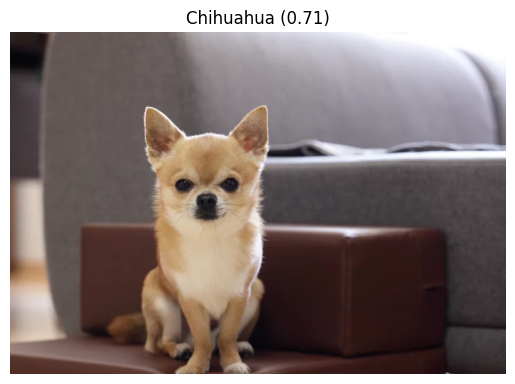

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


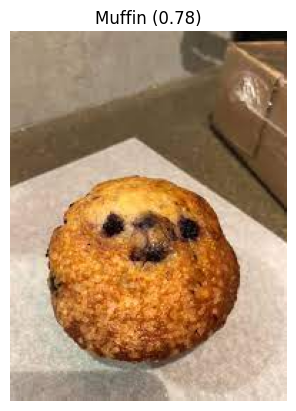

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


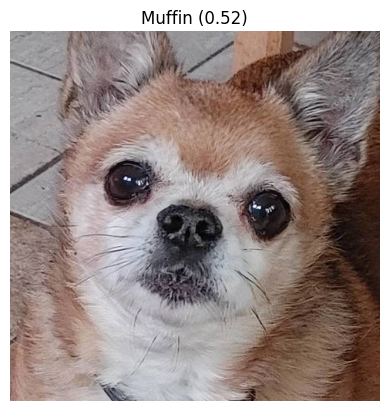

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


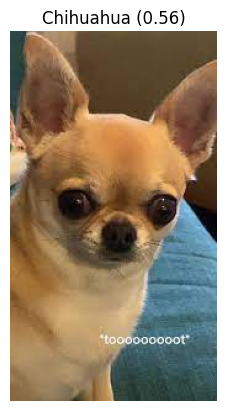

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


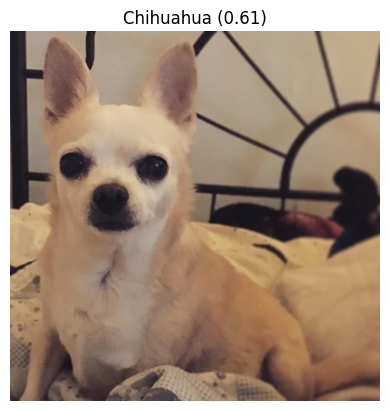

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


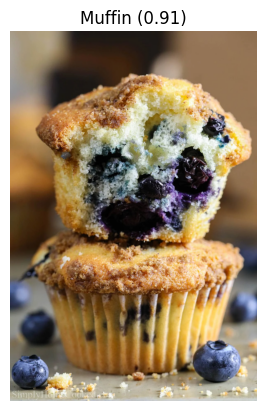

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


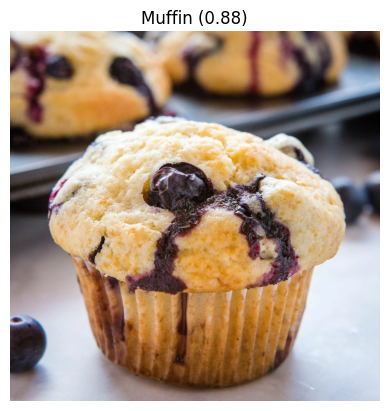

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


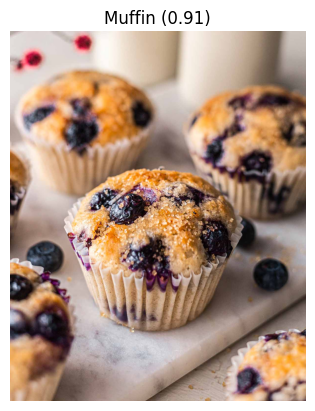

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


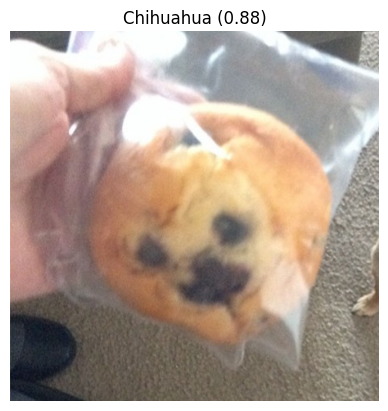

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


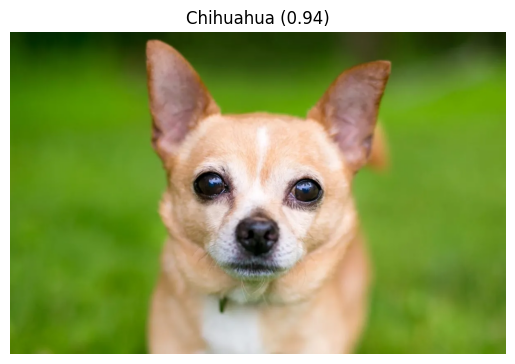

In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_file in image_files:
    img_path = os.path.join(predict_dir, img_file)
    result = predict_image(img_path, model)

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(result)
    plt.axis('off')
    plt.show()